In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

from PIL import Image
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
import cv2
import os
from tqdm import tqdm

In [3]:
# Using the Kaggle API
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [6]:
!kaggle datasets download -d nikitarom/planets-dataset

100% 1.50G/1.50G [00:48<00:00, 38.7MB/s]
100% 1.50G/1.50G [00:48<00:00, 33.0MB/s]


In [7]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

In [8]:
!ls /content/planet/planet

sample_submission.csv  test-jpg  train_classes.csv  train-jpg


In [9]:
path = "/content/planet/planet"
train_path = os.path.join(path, "train-jpg")
test_path = os.path.join(path, "test-jpg")
class_path = os.path.join(path, "train_classes.csv")
submission_path = os.path.join(path, "sample_submission.csv")

In [10]:
#reading the labels
df = pd.read_csv(class_path)
submission_df = pd.read_csv(submission_path)

print(df.shape)
print(submission_df.shape)

(40479, 2)
(61191, 2)


In [11]:
label_list = []
for tag_split in df.tags.to_numpy():
    labels = tag_split.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [12]:
print(len(label_list))

17


In [13]:
labels_dict = dict(zip(range(0,17), label_list))
labels_dict

{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}

In [14]:
# One-hot encode the features
for label in label_list:
    df[label] = df['tags'].apply(lambda x: 1 if label in x.split() else 0)
    
df.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


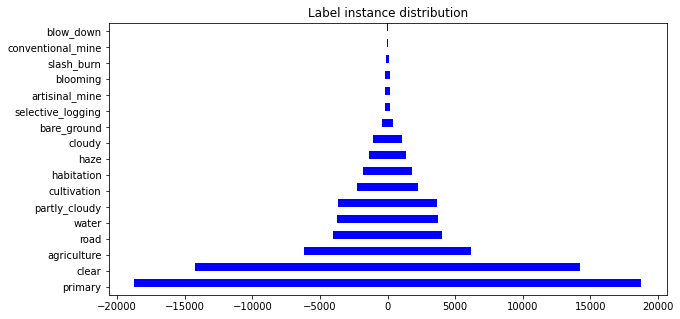

In [15]:
# plot the labels      
df[label_list].sum().sort_values(ascending=False)\
.plot(kind='barh', title='Label instance distribution', orientation= 'vertical', figsize=(10, 5), color='blue')
plt.show()

In [16]:
import gc
gc.collect()

4159

In [17]:
# for the analysis we need columns after tag and image_name
df_columns = list(df.columns[2:])
# print(df_columns,end='')

In [18]:
# Onehot encode the image name
df['image_name'] = df['image_name'].apply(lambda x: f'{x}.jpg')
df.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
import gc
gc.collect()

0

In [20]:
def f_beta_score(y_true, y_pred, beta = 2, epsilon = 1e-4):
    
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp +fp +epsilon)
    recall = tp/(tp + fn + epsilon)
    
    return (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)


In [21]:
def accuracy_score(y_true, y_pred, epsilon = 1e-4):
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), 
                       axis = 1)
    return (tp + tn)/(tp + tn + fp + fn + epsilon)

In [22]:
import gc
gc.collect()

0

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# train_set contains 80 percent of images
train_gen = train_datagen.flow_from_dataframe(dataframe=df,
                                              directory = train_path,  
                                              x_col="image_name", 
                                              y_col=df_columns, 
                                              subset="training", 
                                              batch_size=128,
                                              seed=42, 
                                              shuffle = True, 
                                              class_mode="raw", 
                                              target_size=(128,128))


# val_set contains 20 percent of images 
val_gen = train_datagen.flow_from_dataframe(dataframe=df,
                                            directory = train_path,  
                                            x_col="image_name", 
                                            y_col=df_columns, 
                                            subset="validation", 
                                            batch_size=128,
                                            seed=42, 
                                            shuffle = True, 
                                            class_mode="raw", 
                                            target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [24]:
def model_building():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    return model
    

In [25]:
model = model_building()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        1

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f_beta_score, accuracy_score])

# Save the callback
callback = EarlyStopping(
    monitor="val_loss", 
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

In [27]:
# Batchsize for training and validation set
train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // train_gen.batch_size

In [28]:
import gc
gc.collect()

146

In [29]:
history = model.fit(x=train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=15,
                    callbacks=[callback]) 

Epoch 1/15
253/253 [==============================] - 139s 499ms/step - loss: 0.2425 - f_beta_score: 0.6677 - accuracy_score: 0.9067 - val_loss: 0.2097 - val_f_beta_score: 0.6946 - val_accuracy_score: 0.9172
Epoch 2/15
253/253 [==============================] - 108s 425ms/step - loss: 0.1714 - f_beta_score: 0.7775 - accuracy_score: 0.9335 - val_loss: 0.1561 - val_f_beta_score: 0.7684 - val_accuracy_score: 0.9379
Epoch 3/15
253/253 [==============================] - 107s 423ms/step - loss: 0.1536 - f_beta_score: 0.7962 - accuracy_score: 0.9394 - val_loss: 0.1407 - val_f_beta_score: 0.8014 - val_accuracy_score: 0.9432
Epoch 4/15
253/253 [==============================] - 105s 416ms/step - loss: 0.1462 - f_beta_score: 0.8080 - accuracy_score: 0.9423 - val_loss: 0.1343 - val_f_beta_score: 0.8197 - val_accuracy_score: 0.9475
Epoch 5/15
253/253 [==============================] - 107s 421ms/step - loss: 0.1367 - f_beta_score: 0.8218 - accuracy_score: 0.9453 - val_loss: 0.1275 - val_f_beta_sco

In [30]:
import gc
gc.collect()

4

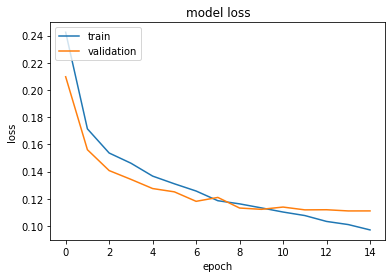

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
# Test data: divide the submission dataframe into two splits as the image names after 40669 is different 
test_df = submission_df.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)

In [33]:
test_df['image_name'] = submission_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
test_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [34]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                            directory = test_path,  
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=67,
                                            shuffle=False,
                                            class_mode=None, 
                                            target_size=(128,128))

test_size = test_gen.n // test_gen.batch_size

Found 40669 validated image filenames.


In [35]:
pred = model.predict(test_gen, steps=test_size, verbose=1)

607/607 [==============================] - 105s 172ms/step


In [36]:
test_names = test_gen.filenames 
        
test_result = pd.DataFrame(pred)
test_result = test_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

test_result_df = pd.DataFrame({'image_name': test_names, 'tags': test_result})
test_result_df.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary water partly_cloudy


In [37]:
# additional batch of the test dataset
additional_df = submission_df.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)

In [38]:
additional_df['image_name'] = additional_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [39]:
additional_gen = test_datagen.flow_from_dataframe(dataframe=additional_df,
                                                  directory="/content/test-jpg-additional/test-jpg-additional", 
                                                  x_col='image_name',
                                                  y_col = None,
                                                  batch_size=62,
                                                  shuffle=False,
                                                  class_mode=None, 
                                                  target_size=(128, 128))


additional_step = additional_gen.n // additional_gen.batch_size

Found 20522 validated image filenames.


In [40]:
# predicted probabilities for each class
pred_additional = model.predict(additional_gen, steps=additional_step, verbose=1)

331/331 [==============================] - 64s 191ms/step


In [41]:
additional_names = additional_gen.filenames 
        
additional_result = pd.DataFrame(pred_additional)
additional_result = additional_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

additional_result_df = pd.DataFrame({'image_name': additional_names, 'tags': additional_result})
additional_result_df.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,primary agriculture clear road cultivation par...
2,file_10.jpg,haze primary agriculture water road
3,file_100.jpg,primary agriculture clear water road
4,file_1000.jpg,primary clear


In [42]:
final_result = pd.concat([test_result_df, additional_result_df])

final_result = final_result.reset_index().drop('index', axis =1)

final_result

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary water partly_cloudy
...,...,...
61186,file_9995.jpg,primary cloudy partly_cloudy
61187,file_9996.jpg,primary agriculture clear water
61188,file_9997.jpg,primary clear water road
61189,file_9998.jpg,cloudy


In [43]:
# Remove the .jpg extension from the image_name of the final_result
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary water partly_cloudy
...,...,...
61186,file_9995,primary cloudy partly_cloudy
61187,file_9996,primary agriculture clear water
61188,file_9997,primary clear water road
61189,file_9998,cloudy


In [44]:
# save the results to a CSV file save and set the index to false.
final_result.to_csv('mySubmission2.csv', index=False)